In [1]:
#@title 1. MONTAR EL DRIVE { display-mode: "form" }
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ProyectoFinal')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/ProyectoFinal


# Estudio del COVID-19 utilizando IA

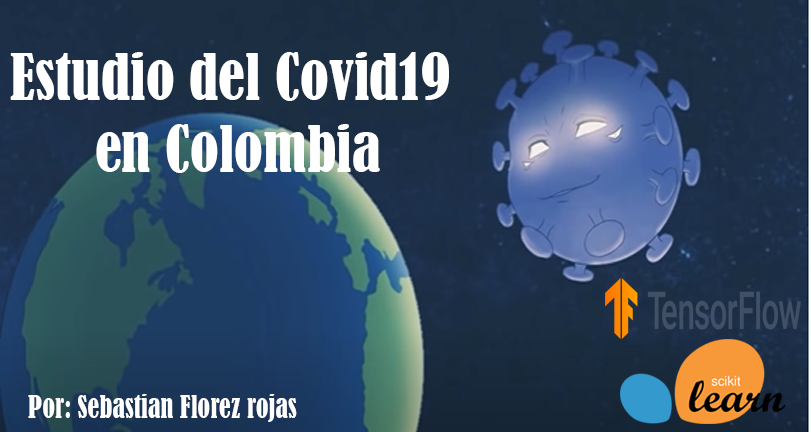

In [ ]:
from IPython.display import Image, display
display(Image('bannerIA.png'))

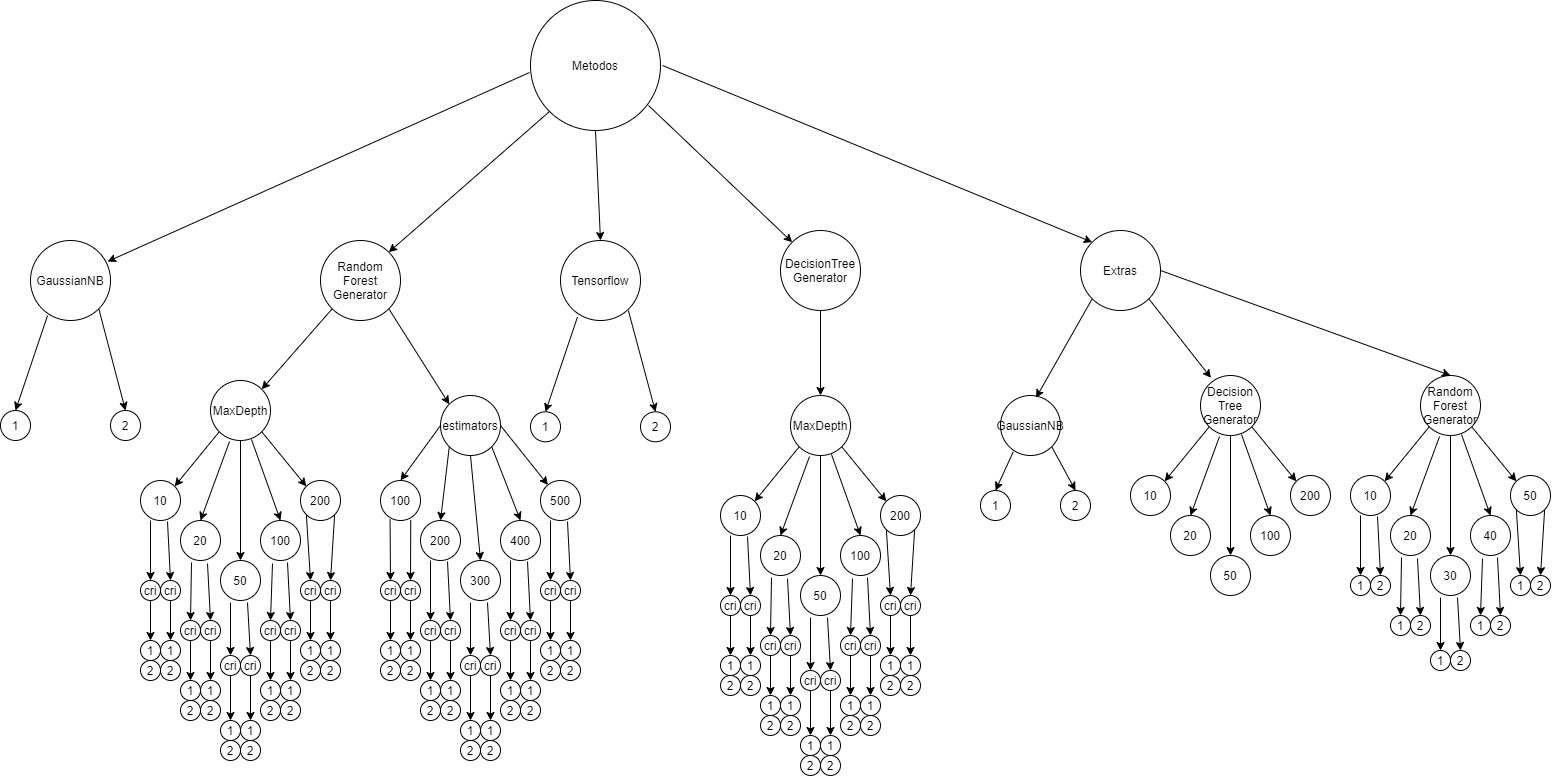

In [ ]:
from IPython.display import Image, display
display(Image('PAINDIAGRAM.png'))

# INTRODUCCION

Este proyecto tiene como objetivo utilizar los metodos de inteligencia artificial enseñados a lo largo de semestre para tratar de realizar predicciones respecto a distintos aspectos del covid y sacar diversas conclusiones del dataset y la informacion proveida a partir de esta.

Para comenzar, el primer paso es importar todas las librerias que se van a utilizar a lo largo de todo el proyecto ademas del dataset a utilizar.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
from collections import Counter
from tensorflow import keras
import sys
import tensorflow as tf
from sklearn.tree import DecisionTreeClassifier
tr1 = pd.read_csv('Datos/Casos.csv')
tr1.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,17,19,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


fecha reporte web  ID de caso  ... Pertenencia étnica  Nombre del grupo étnico
0   6/3/2020 0:00:00           1  ...                6.0                      NaN
1   9/3/2020 0:00:00           2  ...                5.0                      NaN
2   9/3/2020 0:00:00           3  ...                6.0                      NaN
3  11/3/2020 0:00:00           4  ...                6.0                      NaN
4  11/3/2020 0:00:00           5  ...                6.0                      NaN

[5 rows x 23 columns]

Como se puede observar, el dataset contiene mucha informacion relacionada no con factores relevantes a la enfermedad en si sino a las personas o como metodos de identificacion. Por ello, se van a tomar los factores mas relevantes del dataset a la hora de realizar predicciones sobre la enfermedad. En este caso, el estado, si el paciente se recupero o murio, el tipo de contagio, la edad y el sexo. 

Para comenzar el analisis, se va a determinar un pivote o dato a analizar. El estado de los pacientes, pero antes de comenzar, hay que estudiar la variedad de los datos que se esta tratando.

In [ ]:
graves = tr1[tr1.Estado=="Grave"]
leves = tr1[tr1.Estado=="Leve"]
alt = tr1[["Edad", "Sexo", "Estado"]]
alt=alt.values
graves.head()
DatosGraves=graves[["Edad", "Sexo", "Estado"]]
DatosLeves=leves[["Edad", "Sexo", "Estado"]]
DatosRelevantes = tr1[["Edad", "Sexo", "Estado"]]
print(graves.size)
print(leves.size)

78683
40663655


Tal como se pudo observar, hay una cantidad mucho mayor de casos leves que graves lo cual podria dar problemas a la hora de realizar predicciones, por ello, vamos a recortar los datos con los que tratar.

In [ ]:
DatosaUsar=tr1[["Edad","Sexo", "Estado"]]
graves = DatosaUsar[DatosaUsar.Estado=="Grave"]
leves = DatosaUsar[DatosaUsar.Estado=="Leve"]
TakenGraves=graves.head(3000)
TakenLeves=leves.head(3000)
DatosaUsar = pd.concat([TakenGraves, TakenLeves])
DatosaUsar = np.random.permutation(DatosaUsar)
X= DatosaUsar[:,[0,1]]
Xless = DatosaUsar[:,0]
Y= DatosaUsar[:,2]
a,b = X.shape
a2, b = alt.shape
n2 = int(a2*0.8)
Yalt= alt[:,2]
Xalt= alt[:,[0,1]]
XaltTrain = X[:n2,:]
XaltTest = X[n2:,:]
YaltTrain = Y[:n2]
YaltTest = Y[n2:]

Yalt= alt[:,2]
Xalt= alt[:,[0,1]]

p=0
for j in range(0,a):  
  for i in X[j,1]:
    if i == "F":
      X[j,1]=0
    if i == "M":
      X[j,1]=1

for k in range(0,a2):  
  for l in Xalt[k,1]:
    if l == "F":
      Xalt[k,1]=0
      p=p+1
    if l == "M":
      Xalt[k,1]=1
      p=p+1

En primer lugar, vamos a estudiar la relevancia de los datos seleccionados para hacer predicciones sobre el estado de los pacientes ahora que los datos ya han sido arreglados y seleccionados.

# ANALISIS DE DATOS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed24ca2cc0>]],
      dtype=object)

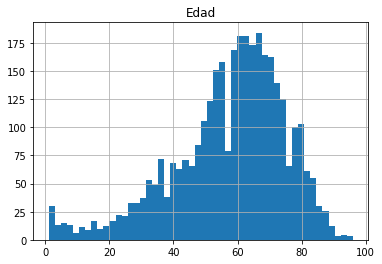

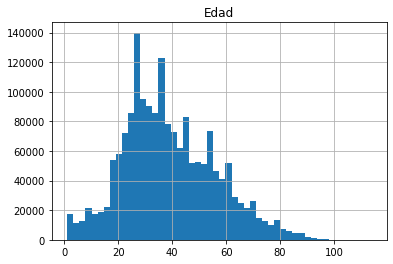

In [ ]:
graves.hist('Edad', bins =50)
leves.hist('Edad', bins =50)

De las graficas se pueden sacar varias conclusiones. En primer lugar, la edad es un factor que se puede utilizar para determinar la posibilidad de que un caso sea grave ya que entre mayor la edad mas comun es que fuera un caso grave.

Ademas de ello, tambien se puede observar picos en ciertas edades en las edades de los pacientes leves pero se onclinan a estar en los pacientes jovenes. Ademas de ello, tambien cabe recalcar que aun asi hay una gran cantidad de casos leves en edades mayores debido a que hay muchos mas casos leves que graves.

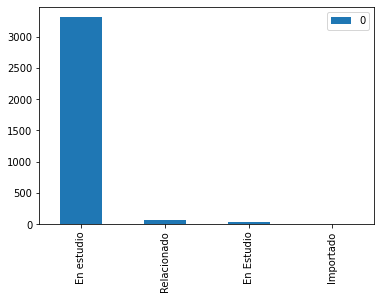

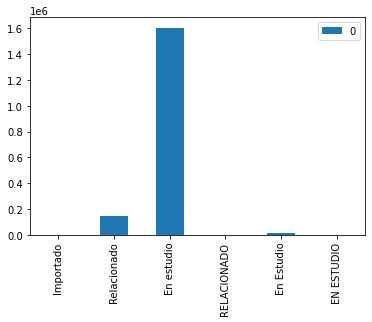

In [ ]:
dat = tr1[["Tipo de contagio", "Estado"]]
Graves = dat[dat.Estado =="Grave"]
Leves = dat[dat.Estado =="Leve"]
GravesCount = Counter(Graves["Tipo de contagio"])
LevesCount = Counter(Leves["Tipo de contagio"])
GravesCount = pd.DataFrame.from_dict(GravesCount, orient='index')
LevesCount = pd.DataFrame.from_dict(LevesCount, orient='index')
GravesCount.plot(kind='bar')
LevesCount.plot(kind='bar')

Desafortunadamente, lo que estas graficas nos dicen es bastante negativo respecto al propio dataset. En primer lugar, los datos de tipo de contagio son casi inutiles ya que casi todos estan en indeterminado. En segundo lugar, se observa como en el caso de los leves hay varias categorias en estudio lo cual implica que no se aplico un estandar a la hora de crear los datos como es comun en este tipo de base de datos. Esto muestra falta de profesionalismo, pero desafortunadamente, no mucho sobre el COVID en si por lo que sera necesario descartar este dato.

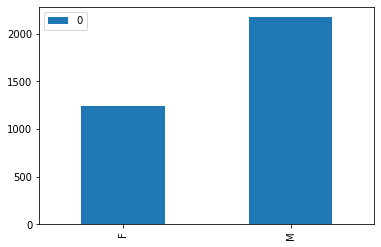

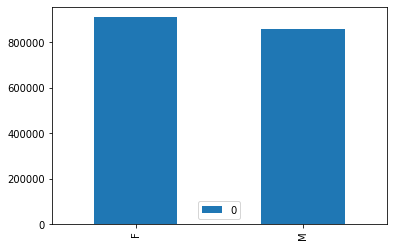

In [ ]:
GravesCount = Counter(graves["Sexo"])
LevesCount = Counter(leves["Sexo"])
GravesCount = pd.DataFrame.from_dict(GravesCount, orient='index')
LevesCount = pd.DataFrame.from_dict(LevesCount, orient='index')
GravesCount.plot(kind='bar')
LevesCount.plot(kind='bar')

Estas son un poco mas curiosas. Ya que inicialmente podria verse como que podrian ser un factor importante a la hora de determinar si es grave o leve ya que hay muchos mas pacientes graves hombres que mujeres. El problema es que la contraparte no se nota en los leves ya que de nuevo, hay una gran diferencia entre ambos. Es cierto que la cantidad de mujeres si es mayor, pero no se podria afirmar que es un criterio adecuado. Por ello, lo mejor seria probar tanto con este dato como sin el.


# Predicciones (50/50 2 bases)

In [ ]:
estimador= GaussianNB()
estimador2 = GaussianNB()
n = int(a*0.8)
a2, b = alt.shape
n2 = int(a2*0.8)

Xrec= Xalt[:1500000,:]
Xtrain= X[:n,:]
Xtest= X[n:,:]
Ytrain= Y[:n]
Ytest= Y[n:]

XaltTrain = Xalt[:n2,:]
XaltTest = Xalt[n2:,:]
YaltTrain = Yalt[:n2]
YaltTest = Yalt[n2:]

estimador.fit(Xtrain, Ytrain)


predicciones= estimador.predict(Xtest)
print( "first 100 predictions", predicciones[:100])
print( "first 100 targets    ", Y[:100])
print("%.3f"%accuracy_score(predicciones, Ytest))

#predicciones2= estimador.predict(XaltTest)
#print( "first 100 predictions", predicciones2[:100])
#print( "first 100 targets    ", Yalt[:100])
#print("%.3f"%accuracy_score(predicciones2, YaltTest))

first 100 predictions ['Grave' 'Grave' 'Leve' 'Grave' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave'
 'Leve' 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Grave' 'Grave' 'Leve' 'Grave'
 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Leve'
 'Grave' 'Grave' 'Grave' 'Grave' 'Grave' 'Grave' 'Leve' 'Leve' 'Grave'
 'Leve' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave' 'Leve' 'Leve' 'Grave' 'Leve'
 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Leve'
 'Grave' 'Grave' 'Grave' 'Leve' 'Grave' 'Leve' 'Leve' 'Grave' 'Leve'
 'Leve' 'Leve' 'Grave' 'Grave' 'Grave' 'Grave' 'Leve' 'Grave' 'Leve'
 'Grave' 'Leve' 'Leve' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave'
 'Grave' 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Grave' 'Grave' 'Leve'
 'Leve' 'Grave' 'Leve' 'Leve' 'Grave' 'Leve']
first 100 targets     ['Grave' 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Leve' 'Grave'
 'Grave' 'Grave' 'Leve' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Leve' 'Grave'
 'Grave' 'Grave' 'Grave' 'Grave' 'Leve' 'Lev

En este primer analisis se utilizo el gaussian naive bayes con un grupo de pruebas con la misma cantidad de leves y graves. En este caso y los siguientes, se esta utilizando tanto la edad como el sexo para tratar de determinar el estado.

In [ ]:
RFCDepth1 =[]
RFCDepth2 =[]
RFCDepth3 =[]
RFCDepth4 =[]
RFCDepth5 =[]
RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))

RFCDepth1 = np.asarray(RFCDepth1)
RFCDepth2 = np.asarray(RFCDepth2)
RFCDepth3 = np.asarray(RFCDepth3)
RFCDepth4 = np.asarray(RFCDepth4)
RFCDepth5 = np.asarray(RFCDepth5)
RFCDepth1 = RFCDepth1.reshape(-1,1)
RFCDepth2 = RFCDepth2.reshape(-1,1)
RFCDepth3 = RFCDepth3.reshape(-1,1)
RFCDepth4 = RFCDepth4.reshape(-1,1)
RFCDepth5 = RFCDepth5.reshape(-1,1)


resultados = [RFCDepth1,RFCDepth2,RFCDepth3,RFCDepth4,RFCDepth5]
resultados = np.asarray(resultados)
print(resultados)


[[[0.695     ]
  [0.69416667]
  [0.6925    ]
  [0.7       ]
  [0.69583333]]

 [[0.695     ]
  [0.69833333]
  [0.69333333]
  [0.69416667]
  [0.6975    ]]

 [[0.69583333]
  [0.69333333]
  [0.6975    ]
  [0.69583333]
  [0.69666667]]

 [[0.69833333]
  [0.6975    ]
  [0.69833333]
  [0.69583333]
  [0.69666667]]

 [[0.69916667]
  [0.69833333]
  [0.69416667]
  [0.69416667]
  [0.69416667]]]


In [ ]:
RFCDepth1 =[]
RFCDepth2 =[]
RFCDepth3 =[]
RFCDepth4 =[]
RFCDepth5 =[]
RFC = RandomForestClassifier(max_depth=10, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))

RFCDepth1 = np.asarray(RFCDepth1)
RFCDepth2 = np.asarray(RFCDepth2)
RFCDepth3 = np.asarray(RFCDepth3)
RFCDepth4 = np.asarray(RFCDepth4)
RFCDepth5 = np.asarray(RFCDepth5)
RFCDepth1 = RFCDepth1.reshape(-1,1)
RFCDepth2 = RFCDepth2.reshape(-1,1)
RFCDepth3 = RFCDepth3.reshape(-1,1)
RFCDepth4 = RFCDepth4.reshape(-1,1)
RFCDepth5 = RFCDepth5.reshape(-1,1)


resultados = [RFCDepth1,RFCDepth2,RFCDepth3,RFCDepth4,RFCDepth5]
resultados = np.asarray(resultados)
print(resultados)

[[[0.69416667]
  [0.6975    ]
  [0.69416667]
  [0.695     ]
  [0.69416667]]

 [[0.69416667]
  [0.69333333]
  [0.7       ]
  [0.6975    ]
  [0.69583333]]

 [[0.69666667]
  [0.69833333]
  [0.69333333]
  [0.6975    ]
  [0.695     ]]

 [[0.69916667]
  [0.69833333]
  [0.695     ]
  [0.69583333]
  [0.69333333]]

 [[0.695     ]
  [0.69916667]
  [0.6925    ]
  [0.69333333]
  [0.69333333]]]


El segundo analisis se realizo con los mismos datos de entrenamiento y prueba que la primera, pero se utilizo el clasificador RandomForestClasifier obteniendo un resultado de precision menor que el anterior. 

In [ ]:
DTCDepth1 =[]
DTC = DecisionTreeClassifier(max_depth=10, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=20, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=50, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=100, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=200, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
print(DTCDepth1)

[0.6916666666666667, 0.6916666666666667, 0.6916666666666667, 0.6916666666666667, 0.6916666666666667]


In [ ]:
DTCDepth2 =[]
DTC = DecisionTreeClassifier(max_depth=10, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=20, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=50, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=100, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=200, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
print(DTCDepth2)

[0.6958333333333333, 0.6958333333333333, 0.6958333333333333, 0.6958333333333333, 0.6958333333333333]


Al igual que con el randomforestclassifier se realizo el mismo proceso con el randomtreeclassifier en busca de un mejor resultado. Se determino que sin importar la profundidad o el criterio el resultado es el mismo

In [ ]:

dnn1 = keras.models.Sequential([keras.layers.Flatten(input_shape=(Xtrain[0].shape)),
                                keras.layers.Dense(128, activation=tf.nn.relu),
                                keras.layers.Dense(64, activation=tf.nn.relu),
                                keras.layers.Dense(2, activation=tf.nn.softmax)])

dnn1.compile(optimizer = keras.optimizers.SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#x[:,:] = Xtrain[:,:].astype(float)
X = np.asarray(Xtrain).astype(np.int)
X2 = np.asarray(Xtest).astype(np.int)
y=Y
ab = len(y)
for k in range(ab): 
    if y[k] == "Leve":
      y[k]=0
    if y[k] == "Grave":
      y[k]=1
y = np.asarray(y).astype('float32')
yFINALLY1 = y[:n]
yFINALLY2 = y[n:]
dnn1.fit(X, yFINALLY1, epochs = 50)
test_loss, test_acc = dnn1.evaluate(X2, yFINALLY2)
print(test_acc)

Epoch 1/50
150/150 [==============================] - 1s 1ms/step - loss: 1.0492 - accuracy: 0.4868
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.5546
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6625 - accuracy: 0.6120
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6522 - accuracy: 0.6429
Epoch 5/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6479 - accuracy: 0.6651
Epoch 6/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6427 - accuracy: 0.6626
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6428 - accuracy: 0.6564
Epoch 8/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6397 - accuracy: 0.6665
Epoch 9/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.6753
Epoch 10/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6303 - accuracy: 0.6717

Las pruebas realizadas con tensorflow dan resultados bastante similares a los obtenidos con los anteriores. De hecho, aunque es minima, se puede observar que hay una cierta mejora en la precision comparada a los resultados obtenidos por arboles.

# Predicciones 2 (total)

In [ ]:
xtotal = tr1[['Edad','Sexo']]
ytotal = tr1[['Estado']]
xtotal = xtotal.values
ytotal = ytotal.values
aa , asdasr = xtotal.shape
for k in range(0,aa):  
  for l in xtotal[k,1]:
    if l == "F":
      xtotal[k,1]=0
      p=p+1
    if l == "M":
      xtotal[k,1]=1
      p=p+1
xtotal[:,:] = xtotal[:,:].astype(float)
ytotal[:,:] = ytotal[:,:].astype(str)
predic =estimador.predict(xtotal)
print("%.3f"%accuracy_score(predic, ytotal))

0.711


En esta prueba se tomo el dataset entero para realizar una prediccion de todos los datos disponibles. Al realizarla, se puede ver que la precision de las predicciones es similar a la obtenida con el grupo de estudio. Por facilidad, salvo las pruebas finales se seguira trabajando con los grupos de trabajo.

In [ ]:
xtotal = tr1[['Edad','Sexo']]
ytotal = tr1[['Estado']]
xtotal = xtotal.values
ytotal = ytotal.values
aa , asdasr = xtotal.shape
for k in range(0,aa):  
  for l in xtotal[k,1]:
    if l == "F":
      xtotal[k,1]=0
      p=p+1
    if l == "M":
      xtotal[k,1]=1
      p=p+1
xtotal[:,:] = xtotal[:,:].astype(float)
ytotal[:,:] = ytotal[:,:].astype(str)
n= int(aa*0.8)
XultraTrain = xtotal[:n,:]
XultraTest = xtotal[n:,:]
YultraTrain = ytotal[:n]
YultraTest = ytotal[n:]
ultrapredictor= GaussianNB()
ultrapredictor.fit(XultraTrain, YultraTrain)
prediccion =ultrapredictor.predict(XultraTest)
print("%.3f"%accuracy_score(prediccion, YultraTest))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.951


Al realizar un predictor basado en todos los datos del dataset se obtiene una prediccion mucho mayor, pero al analizar las razones tras de esto no es un logro especialmente impresionante.

In [ ]:
DTCDepth2 =[]
DTC = DecisionTreeClassifier(max_depth=10, criterion='entropy')
DTC.fit(XultraTrain, YultraTrain)
DTCDepth2.append(DTC.score(XultraTest, YultraTest))
DTC = DecisionTreeClassifier(max_depth=20, criterion='entropy')
DTC.fit(XultraTrain, YultraTrain)
DTCDepth2.append(DTC.score(XultraTest, YultraTest))
DTC = DecisionTreeClassifier(max_depth=50, criterion='entropy')
DTC.fit(XultraTrain, YultraTrain)
DTCDepth2.append(DTC.score(XultraTest, YultraTest))
DTC = DecisionTreeClassifier(max_depth=100, criterion='entropy')
DTC.fit(XultraTrain, YultraTrain)
DTCDepth2.append(DTC.score(XultraTest, YultraTest))
DTC = DecisionTreeClassifier(max_depth=200, criterion='entropy')
DTC.fit(XultraTrain, YultraTrain)
DTCDepth2.append(DTC.score(XultraTest, YultraTest))
print(DTCDepth2)

[0.9579607431703445, 0.9579364070726109, 0.9579364070726109, 0.9579364070726109, 0.9579364070726109]


Al menos, se puede concluir que en este caso el decisiontreeclassifier es ligeramente mejor que el gaussianNB al contrario del caso equitativo

In [ ]:
RFCDepth1 =[]
RFCDepth2 =[]
RFCDepth3 =[]
RFCDepth4 =[]
RFCDepth5 =[]
RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=100)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth1.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=100)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth1.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=100)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth1.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=100)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth1.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=100)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth1.append(RFC.score(XultraTest, YultraTest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=200)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth2.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=200)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth2.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=200)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth2.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=200)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth2.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=200)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth2.append(RFC.score(XultraTest, YultraTest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=300)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth3.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=300)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth3.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=300)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth3.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=300)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth3.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=300)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth3.append(RFC.score(XultraTest, YultraTest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=400)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth4.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=400)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth4.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=400)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth4.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=400)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth4.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=400)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth4.append(RFC.score(XultraTest, YultraTest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=500)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth5.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=500)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth5.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=500)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth5.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=500)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth5.append(RFC.score(XultraTest, YultraTest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=500)
RFC.fit(XultraTrain, YultraTrain)
RFCDepth5.append(RFC.score(XultraTest, YultraTest))

RFCDepth1 = np.asarray(RFCDepth1)
RFCDepth2 = np.asarray(RFCDepth2)
RFCDepth3 = np.asarray(RFCDepth3)
RFCDepth4 = np.asarray(RFCDepth4)
RFCDepth5 = np.asarray(RFCDepth5)
RFCDepth1 = RFCDepth1.reshape(-1,1)
RFCDepth2 = RFCDepth2.reshape(-1,1)
RFCDepth3 = RFCDepth3.reshape(-1,1)
RFCDepth4 = RFCDepth4.reshape(-1,1)
RFCDepth5 = RFCDepth5.reshape(-1,1)


resultados = [RFCDepth1,RFCDepth2,RFCDepth3,RFCDepth4,RFCDepth5]
resultados = np.asarray(resultados)
print(resultados)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/usr/loc

[[[0.95791748]
  [0.95793641]
  [0.95791748]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]]


Sin contar el exageradamente extenso tiempo que tomo correr el codigo se puede ver que se obtuvieron resultados similares al gaussian NB. Debido al extenso tiempo que tomo realizar este codigo, se tomo la decision de abstenerse de realizar pruebas de similar envergadura por el resto del proyecto.

#Predicciones 3 (50/50 1 base)

In [ ]:
estimador= GaussianNB()
n = int(a*0.8)
a2, b = alt.shape
n2 = int(a2*0.8)


Xtrain= Xless[:n]
Xtest= Xless[n:]
Ytrain= Y[:n]
Ytest= Y[n:]

Ytrain = Ytrain.reshape(-1,1)
Xtrain = Xtrain.reshape(-1,1)
Xtest = Xtest.reshape(-1,1)
Ytest = Ytest.reshape(-1,1)
estimador.fit(Xtrain, Ytrain)

predicciones= estimador.predict(Xtest)
print( "first 100 predictions", predicciones[:100])
print( "first 100 targets    ", Y[:100])
print("%.3f"%accuracy_score(predicciones, Ytest))

#predicciones2= estimador.predict(XaltTest)
#print( "first 100 predictions", predicciones2[:100])
#print( "first 100 targets    ", Yalt[:100])
#print("%.3f"%accuracy_score(predicciones2, YaltTest))

first 100 predictions ['Grave' 'Grave' 'Leve' 'Grave' 'Leve' 'Leve' 'Grave' 'Grave' 'Leve'
 'Grave' 'Leve' 'Leve' 'Leve' 'Grave' 'Grave' 'Leve' 'Grave' 'Leve'
 'Grave' 'Leve' 'Grave' 'Grave' 'Leve' 'Leve' 'Grave' 'Grave' 'Grave'
 'Leve' 'Grave' 'Grave' 'Grave' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave'
 'Grave' 'Leve' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Grave'
 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Leve' 'Leve' 'Leve' 'Grave'
 'Leve' 'Grave' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Leve'
 'Leve' 'Leve' 'Grave' 'Grave' 'Leve' 'Leve' 'Leve' 'Leve' 'Grave' 'Leve'
 'Grave' 'Leve' 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Grave' 'Leve'
 'Leve' 'Grave' 'Leve' 'Leve' 'Leve' 'Leve' 'Leve' 'Grave' 'Grave' 'Grave'
 'Leve' 'Grave' 'Grave' 'Grave' 'Leve' 'Leve' 'Leve']
first 100 targets     ['Grave' 'Grave' 'Grave' 'Leve' 'Leve' 'Grave' 'Grave' 'Grave' 'Grave'
 'Grave' 'Leve' 'Grave' 'Grave' 'Grave' 'Leve' 'Grave' 'Grave' 'Leve'
 'Grave' 'Grave' 'Leve' 'Leve' 'Grave' 'Grave' 'Leve'

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Se rehace la prediccion primera pero eliminando el factor de sexo de los datos para preparar los predictores. De esta manera, se puede entender s es mejor tomarlo en cuenta o no.

In [ ]:
RFCDepth1 =[]
RFCDepth2 =[]
RFCDepth3 =[]
RFCDepth4 =[]
RFCDepth5 =[]
RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, criterion = 'entropy', n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))

RFCDepth1 = np.asarray(RFCDepth1)
RFCDepth2 = np.asarray(RFCDepth2)
RFCDepth3 = np.asarray(RFCDepth3)
RFCDepth4 = np.asarray(RFCDepth4)
RFCDepth5 = np.asarray(RFCDepth5)
RFCDepth1 = RFCDepth1.reshape(-1,1)
RFCDepth2 = RFCDepth2.reshape(-1,1)
RFCDepth3 = RFCDepth3.reshape(-1,1)
RFCDepth4 = RFCDepth4.reshape(-1,1)
RFCDepth5 = RFCDepth5.reshape(-1,1)


resultados = [RFCDepth1,RFCDepth2,RFCDepth3,RFCDepth4,RFCDepth5]
resultados = np.asarray(resultados)
print(resultados)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/usr/loc

[[[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.695     ]]

 [[0.695     ]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]]


In [ ]:
RFCDepth1 =[]
RFCDepth2 =[]
RFCDepth3 =[]
RFCDepth4 =[]
RFCDepth5 =[]
RFC = RandomForestClassifier(max_depth=10, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=100)
RFC.fit(Xtrain, Ytrain)
RFCDepth1.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=200)
RFC.fit(Xtrain, Ytrain)
RFCDepth2.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=300)
RFC.fit(Xtrain, Ytrain)
RFCDepth3.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=400)
RFC.fit(Xtrain, Ytrain)
RFCDepth4.append(RFC.score(Xtest, Ytest))

RFC = RandomForestClassifier(max_depth=10, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=20, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=30, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=40, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))
RFC = RandomForestClassifier(max_depth=50, n_estimators=500)
RFC.fit(Xtrain, Ytrain)
RFCDepth5.append(RFC.score(Xtest, Ytest))

RFCDepth1 = np.asarray(RFCDepth1)
RFCDepth2 = np.asarray(RFCDepth2)
RFCDepth3 = np.asarray(RFCDepth3)
RFCDepth4 = np.asarray(RFCDepth4)
RFCDepth5 = np.asarray(RFCDepth5)
RFCDepth1 = RFCDepth1.reshape(-1,1)
RFCDepth2 = RFCDepth2.reshape(-1,1)
RFCDepth3 = RFCDepth3.reshape(-1,1)
RFCDepth4 = RFCDepth4.reshape(-1,1)
RFCDepth5 = RFCDepth5.reshape(-1,1)


resultados = [RFCDepth1,RFCDepth2,RFCDepth3,RFCDepth4,RFCDepth5]
resultados = np.asarray(resultados)
print(resultados)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/usr/loc

[[[0.695     ]
  [0.69416667]
  [0.695     ]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.695     ]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]]


Se rehacen las pruebas con el randomforestgenerator. Tal como en el caso anterior, todos los resultados son el mismo.

In [ ]:
DTCDepth1 =[]
DTC = DecisionTreeClassifier(max_depth=10, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=20, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=50, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=100, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=200, criterion='gini')
DTC.fit(Xtrain, Ytrain)
DTCDepth1.append(DTC.score(Xtest, Ytest))
print(DTCDepth1)

[0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667]


In [ ]:
DTCDepth2 =[]
DTC = DecisionTreeClassifier(max_depth=10, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=20, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=50, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=100, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
DTC = DecisionTreeClassifier(max_depth=200, criterion='entropy')
DTC.fit(Xtrain, Ytrain)
DTCDepth2.append(DTC.score(Xtest, Ytest))
print(DTCDepth2)

[0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667]


In [ ]:
dnn1 = keras.models.Sequential([keras.layers.Flatten(input_shape=(Xtrain[0].shape)),
                                keras.layers.Dense(128, activation=tf.nn.relu),
                                keras.layers.Dense(64, activation=tf.nn.relu),
                                keras.layers.Dense(2, activation=tf.nn.softmax)])

dnn1.compile(optimizer = keras.optimizers.SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#x[:,:] = Xtrain[:,:].astype(float)
X = np.asarray(Xtrain).astype(np.int)
X2 = np.asarray(Xtest).astype(np.int)
y=Y
ab = len(y)
for k in range(ab): 
    if y[k] == "Leve":
      y[k]=0
    if y[k] == "Grave":
      y[k]=1
y = np.asarray(y).astype('float32')
yFINALLY1 = y[:n]
yFINALLY2 = y[n:]
dnn1.fit(X, yFINALLY1, epochs = 50)
test_loss, test_acc = dnn1.evaluate(X2, yFINALLY2)
print(test_acc)

Epoch 1/50
150/150 [==============================] - 1s 1ms/step - loss: 1.6972 - accuracy: 0.5038
Epoch 2/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6702 - accuracy: 0.5654
Epoch 3/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6594 - accuracy: 0.6181
Epoch 4/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6530 - accuracy: 0.6502
Epoch 5/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6477 - accuracy: 0.6566
Epoch 6/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6440 - accuracy: 0.6617
Epoch 7/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6396 - accuracy: 0.6838
Epoch 8/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6387 - accuracy: 0.6714
Epoch 9/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6308 - accuracy: 0.6898
Epoch 10/50
150/150 [==============================] - 0s 1ms/step - loss: 0.6239 - accuracy: 0.6924

#Conclusiones

Los resultados de cada prueba son

#Pruebas1:


**GaussianNB:** 0.718


**RandomForestClassifier1:**[[[0.695     ]
  [0.69416667]
  [0.6925    ]
  [0.7       ]
  [0.69583333]]

 [[0.695     ]
  [0.69833333]
  [0.69333333]
  [0.69416667]
  [0.6975    ]]

 [[0.69583333]
  [0.69333333]
  [0.6975    ]
  [0.69583333]
  [0.69666667]]

 [[0.69833333]
  [0.6975    ]
  [0.69833333]
  [0.69583333]
  [0.69666667]]

 [[0.69916667]
  [0.69833333]
  [0.69416667]
  [0.69416667]
  [0.69416667]]]


**RandomForestClassifier2:**[[[0.69416667]
  [0.6975    ]
  [0.69416667]
  [0.695     ]
  [0.69416667]]

 [[0.69416667]
  [0.69333333]
  [0.7       ]
  [0.6975    ]
  [0.69583333]]

 [[0.69666667]
  [0.69833333]
  [0.69333333]
  [0.6975    ]
  [0.695     ]]

 [[0.69916667]
  [0.69833333]
  [0.695     ]
  [0.69583333]
  [0.69333333]]

 [[0.695     ]
  [0.69916667]
  [0.6925    ]
  [0.69333333]
  [0.69333333]]]


**DecissionTreeClassifier1:**[0.6916666666666667, 0.6916666666666667, 0.6916666666666667, 0.6916666666666667, 0.6916666666666667]


**DecissionTreeClassifier2:**[0.6958333333333333, 0.6958333333333333, 0.6958333333333333, 0.6958333333333333, 0.6958333333333333]


**Keras:** 0.7058333158493042




#Pruebas2:


**GaussianNB(50/50):** 0.711


**GaussianNB:** 0.951


**DecissionTreeClassifier:**[0.9579607431703445, 0.9579364070726109, 0.9579364070726109, 0.9579364070726109, 0.9579364070726109]


**RandomForestClassifier:**[[[0.95791748]
  [0.95793641]
  [0.95791748]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]

 [[0.95791748]
  [0.95793641]
  [0.95793641]
  [0.95793641]
  [0.95793641]]]




#Pruebas3:


**GaussianNB:** 0.698


**RandomForestClassifier1:**[[[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.695     ]]

 [[0.695     ]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]]


**RandomForestClassifier2:**[[[0.695     ]
  [0.69416667]
  [0.695     ]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.695     ]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]

 [[0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]
  [0.69666667]]]


**DecissionTreeClassifier1:**[0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667]


**DecissionTreeClassifier2:**[0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667, 0.6966666666666667]


**Keras:** 0.66